In [2]:
import rasterio
import os
import numpy as np
from PIL import Image
import cv2
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from matplotlib import pyplot as plt
import random

In [3]:
minmaxscaler = MinMaxScaler()

In [4]:
dataset_root_folder = "D:/forest_fire"

In [5]:
image_patch_size = 256
label_patch_size=  256

In [11]:
# Initialize datasets as lists
image_dataset = []
mask_dataset = []

# Number of images and labels (you can change this range as per your data)
num_images = 2  # Number of images and labels to process (change as needed)

# Define dataset paths
image_folder = f'{dataset_root_folder}/images'
mask_folder = f'{dataset_root_folder}/labels'

# Initialize the MinMaxScaler for scaling
minmaxscaler = MinMaxScaler()

# Loop through each image and corresponding label
for idx in range(1, num_images + 1): 
    # Process raster image with multiple bands
    image_path = f'{image_folder}/image_{idx}.tif'
    mask_path = f'{mask_folder}/label_{idx}.tif'

    # Process image
    with rasterio.open(image_path) as src:
        image = src.read()  # Read all bands
        image = np.moveaxis(image, 0, -1)  # Rearrange dimensions to (H, W, Bands)

        # Resize to patchable size
        size_x = (image.shape[1] // image_patch_size) * image_patch_size
        size_y = (image.shape[0] // image_patch_size) * image_patch_size
        # Crop the image to match the patch size
        image = image[:size_y, :size_x, :]

        # Patchify the image
        patched_images = patchify(image, (image_patch_size, image_patch_size, image.shape[-1]), step=image_patch_size)

        # Loop through each patch
        for i in range(patched_images.shape[0]):
            for j in range(patched_images.shape[1]):
                individual_patched_image = patched_images[i, j, :, :]
                individual_patched_image = individual_patched_image[0]  # Remove unnecessary extra dimension

                # Normalize the image patches using MinMaxScaler
                individual_patched_image = minmaxscaler.fit_transform(individual_patched_image.reshape(-1, individual_patched_image.shape[-1])).reshape(individual_patched_image.shape)

                # Append the patch to the image dataset list
                image_dataset.append(individual_patched_image)

    # Process corresponding mask in GeoTIFF format
    with rasterio.open(mask_path) as src:
        mask = src.read(1)  # Read only the first band (assuming mask is single-band)

        # Resize to patchable size
        size_x = (mask.shape[1] // image_patch_size) * image_patch_size
        size_y = (mask.shape[0] // image_patch_size) * image_patch_size
        # Crop the mask to match the patch size
        mask = mask[:size_y, :size_x]

        # Patchify the mask (use (patch_size, patch_size) since mask is 2D)
        patched_masks = patchify(mask, (image_patch_size, image_patch_size), step=image_patch_size)

        # Loop through each mask patch
        for i in range(patched_masks.shape[0]):
            for j in range(patched_masks.shape[1]):
                individual_patched_mask = patched_masks[i, j, :, :]  # Extract 2D mask patch

                # Add an extra dimension to the mask patch to match image patch dimensions (HxWx1)
                individual_patched_mask = np.expand_dims(individual_patched_mask, axis=-1)

                # Append the mask patch to the mask dataset list
                mask_dataset.append(individual_patched_mask)

# Now image_dataset and mask_dataset should have matching dimensions
print(f"Image patch shape: {image_dataset[0].shape}")
print(f"Mask patch shape: {mask_dataset[0].shape}")


C:\Users\Mathi\anaconda3\envs\lulc_seg\Lib\site-packages\sklearn\utils\_array_api.py:776: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
C:\Users\Mathi\anaconda3\envs\lulc_seg\Lib\site-packages\sklearn\utils\_array_api.py:793: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))
C:\Users\Mathi\anaconda3\envs\lulc_seg\Lib\site-packages\sklearn\utils\_array_api.py:776: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
C:\Users\Mathi\anaconda3\envs\lulc_seg\Lib\site-packages\sklearn\utils\_array_api.py:793: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))
C:\Users\Mathi\anaconda3\envs\lulc_seg\Lib\site-packages\sklearn\utils\_array_api.py:776: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
C:\Users\Mathi\anaconda3\envs\lulc_seg\Lib\site-packages\sklearn\utils\_array_api.py:793: RuntimeWar

Image patch shape: (256, 256, 9)
Mask patch shape: (256, 256, 1)


In [12]:
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)

In [13]:
print(len(image_dataset))
print(len(mask_dataset))

502
502


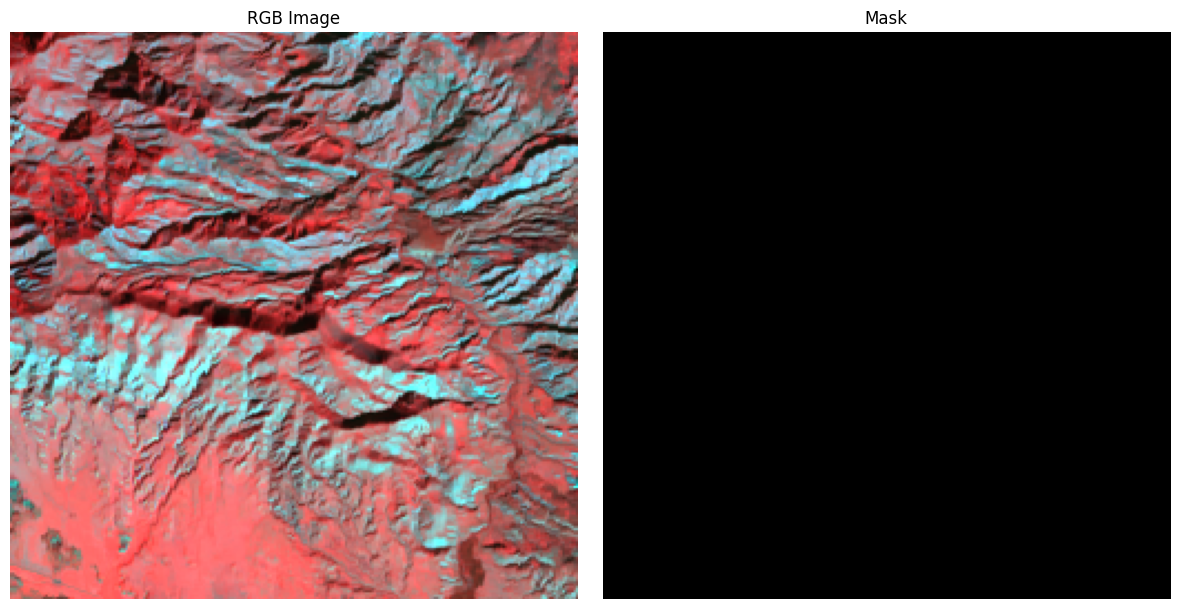

In [14]:

import random
import numpy as np
import matplotlib.pyplot as plt

# Modify the random image selection to ensure we display an image with the required bands
random_image_id = random.randint(0, len(image_dataset) - 1)

# Extract the image corresponding to the random ID
selected_image = image_dataset[random_image_id]

# Assuming the image has more than 3 bands (e.g., Landsat 8), select the appropriate bands for RGB
# Band indices (assuming Landsat 8): Red = Band 4 (index 3), Green = Band 3 (index 2), Blue = Band 2 (index 1)
rgb_image = np.stack([selected_image[:, :, 3],  # Red: Band 4
                      selected_image[:, :, 2],  # Green: Band 3
                      selected_image[:, :, 1]], axis=-1)  # Blue: Band 2

# Normalize the image for display (values between 0 and 1 or 0 and 255)
rgb_image = np.clip(rgb_image / np.percentile(rgb_image, 98), 0, 1)  # Scale by 98th percentile for better contrast

# Extract the corresponding mask (single-band)
selected_mask = mask_dataset[random_image_id]  # Read the first (or only) band

# Plot the RGB image and the mask side by side
plt.figure(figsize=(12, 6))

# Plot the RGB image
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.imshow(rgb_image)
plt.title("RGB Image")
plt.axis("off")

# Plot the corresponding mask
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.imshow(selected_mask[:, :, 0], cmap="gray")  # Use 'gray' colormap for the binary mask
plt.title("Mask")
plt.axis("off")

# Display the images
plt.tight_layout()
plt.show()


In [15]:
label = individual_patched_mask

In [16]:
import numpy as np

# Assuming `mask_dataset` is your input, containing the binary mask images
labels = []

for i in range(len(mask_dataset)):
    # Get the current mask image
    label = mask_dataset[i]

    # Replace NaN values with 0
    label = np.nan_to_num(label, nan=0)

    # Ensure the image is binary (values 0 and 1)
    # If the image is truly binary, we assume fire pixels are represented by any non-zero value
    # Convert everything greater than 0 to 1 (representing fire)
    label = np.where(label > 0, 1, 0)

    # Append the processed binary label to the labels list
    labels.append(label)

# Convert the list of labels into a numpy array
labels = np.array(labels)

# Check the unique values in the labels to confirm binary conversion
print("Unique values in labels:", np.unique(labels))

# `np.unique(labels)` should return `[0, 1]` confirming the binary image



Unique values in labels: [0 1]


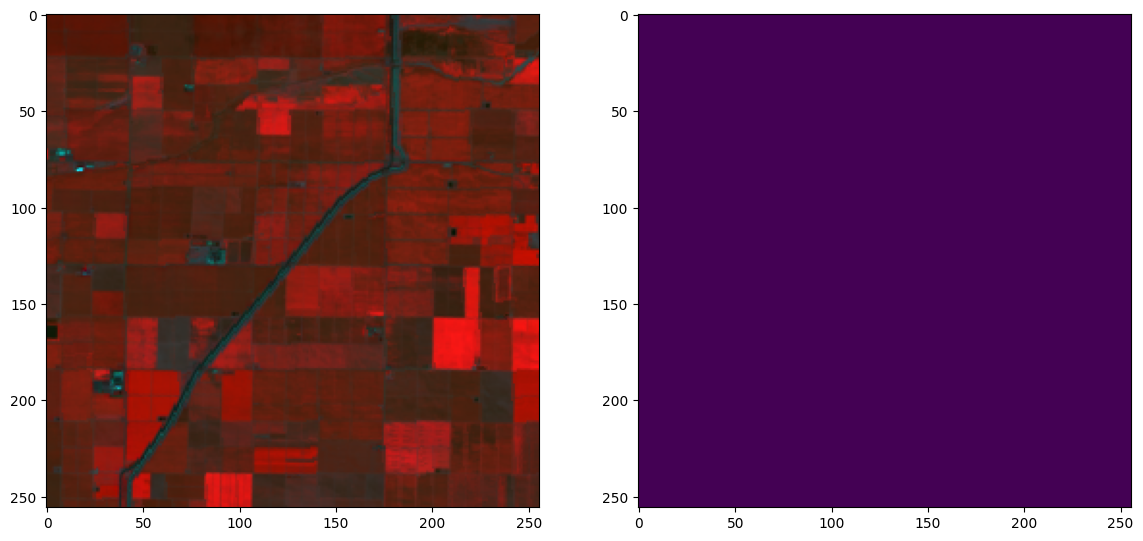

In [17]:
random_image_id = random.randint(0, image_dataset.shape[0] - 1)  # Safe indexing

selected_image = image_dataset[random_image_id]  # Select one image

rgb_image = np.stack([selected_image[:, :, 3],  # Red: Band 4
                      selected_image[:, :, 2],  # Green: Band 3
                      selected_image[:, :, 1]], axis=-1)  # Blue: Band 2

plt.figure(figsize=(14, 8))
plt.subplot(121)
plt.imshow(rgb_image)
plt.subplot(122)
plt.imshow(mask_dataset[random_image_id])  # Mask
plt.imshow(labels[random_image_id][:, :, 0])  # Labels
plt.show()


In [18]:
total_classes = len(np.unique(labels))
total_classes

2

In [19]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split


In [20]:
labels_categorical_dataset = to_categorical(labels, num_classes=total_classes)

In [21]:
master_trianing_dataset = image_dataset

In [22]:
X_train, X_test, y_train, y_test = train_test_split(master_trianing_dataset, labels_categorical_dataset, test_size=0.15, random_state=100)

In [23]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(426, 256, 256, 9)
(76, 256, 256, 9)
(426, 256, 256, 2)
(76, 256, 256, 2)


In [24]:
image_height = X_train.shape[1]
image_width = X_train.shape[2]
image_channels = X_train.shape[3]
total_classes = y_train.shape[3]


In [25]:
print(image_height)
print(image_width)
print(image_channels)
print(total_classes)

256
256
9
2


In [26]:
pip install --upgrade tensorflow keras

Note: you may need to restart the kernel to use updated packages.


In [27]:
import tensorflow as tf
from tensorflow.keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.layers import concatenate, BatchNormalization, Dropout, Lambda

In [28]:
from keras import backend as K

In [29]:
###def jaccard_coef(y_true, y_pred):
 # y_true_flatten = K.flatten(y_true)
  #y_pred_flatten = K.flatten(y_pred)
  #intersection = K.sum(y_true_flatten * y_pred_flatten)
  #final_coef_value = (intersection + 1.0) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection + 1.0)
  #return final_coef_value



def jaccard_coef(y_true, y_pred):
    y_true_flatten = tf.reshape(y_true, [-1])
    y_pred_flatten = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_flatten * y_pred_flatten)
    union = tf.reduce_sum(y_true_flatten) + tf.reduce_sum(y_pred_flatten) - intersection
    return intersection / (union + K.epsilon())



In [30]:
def multi_unet_model(n_classes=5, image_height=256, image_width=256, image_channels=1):

  inputs = Input((image_height, image_width, image_channels))

  source_input = inputs

  c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(source_input)
  c1 = Dropout(0.2)(c1)
  c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c1)
  p1 = MaxPooling2D((2,2))(c1)

  c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p1)
  c2 = Dropout(0.2)(c2)
  c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c2)
  p2 = MaxPooling2D((2,2))(c2)

  c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p2)
  c3 = Dropout(0.2)(c3)
  c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c3)
  p3 = MaxPooling2D((2,2))(c3)

  c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p3)
  c4 = Dropout(0.2)(c4)
  c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c4)
  p4 = MaxPooling2D((2,2))(c4)

  c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p4)
  c5 = Dropout(0.2)(c5)
  c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c5)

  u6 = Conv2DTranspose(128, (2,2), strides=(2,2), padding="same")(c5)
  u6 = concatenate([u6, c4])
  c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u6)
  c6 = Dropout(0.2)(c6)
  c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c6)

  u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding="same")(c6)
  u7 = concatenate([u7, c3])
  c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u7)
  c7 = Dropout(0.2)(c7)
  c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c7)

  u8 = Conv2DTranspose(32, (2,2), strides=(2,2), padding="same")(c7)
  u8 = concatenate([u8, c2])
  c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u8)
  c8 = Dropout(0.2)(c8)
  c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c8)

  u9 = Conv2DTranspose(16, (2,2), strides=(2,2), padding="same")(c8)
  u9 = concatenate([u9, c1], axis=3)
  c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u9)
  c9 = Dropout(0.2)(c9)
  c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c9)

  outputs = Conv2D(n_classes, (1,1), activation="softmax")(c9)

  model = Model(inputs=[inputs], outputs=[outputs])
  return model



In [31]:
metrics = ["accuracy", jaccard_coef]

In [32]:
print(image_height)
print(image_width)
print(image_channels)
print(total_classes)

256
256
9
2


In [33]:
def get_deep_learning_model():
  return multi_unet_model(n_classes=total_classes,
                          image_height=image_height,
                          image_width=image_width,
                          image_channels=image_channels)

In [34]:
model = get_deep_learning_model()

In [35]:
 model.get_config()

{'name': 'functional',
 'trainable': True,
 'layers': [{'module': 'keras.layers',
   'class_name': 'InputLayer',
   'config': {'batch_shape': (None, 256, 256, 9),
    'dtype': 'float32',
    'sparse': False,
    'name': 'input_layer'},
   'registered_name': None,
   'name': 'input_layer',
   'inbound_nodes': []},
  {'module': 'keras.layers',
   'class_name': 'Conv2D',
   'config': {'name': 'conv2d',
    'trainable': True,
    'dtype': {'module': 'keras',
     'class_name': 'DTypePolicy',
     'config': {'name': 'float32'},
     'registered_name': None},
    'filters': 16,
    'kernel_size': (3, 3),
    'strides': (1, 1),
    'padding': 'same',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'groups': 1,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'module': 'keras.initializers',
     'class_name': 'HeNormal',
     'config': {'seed': None},
     'registered_name': None},
    'bias_initializer': {'module': 'keras.initializers',
     'cla

In [36]:
weights = [0.5, 0.5]

In [37]:
!pip install -U -q segmentation-models
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

In [38]:
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [39]:
dice_loss = sm.losses.DiceLoss(class_weights = weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

In [40]:
import tensorflow as tf

In [41]:
tf.keras.backend.clear_session()

In [42]:
model.compile(optimizer="adam", loss=total_loss, metrics=metrics)

In [43]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 9)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,312 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256, 256,  │          0 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      2,320 │ dropout[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128, 128,  │          0 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      9,248 │ dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │     36,928 │ dropout_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │    147,584 │ dropout_3[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]  

 Total params: 1,941,986 (7.41 MB)

 Trainable params: 1,941,986 (7.41 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:
from tensorflow.keras.callbacks import EarlyStopping

# Define EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', # or 'val_accuracy'
                               patience=5,         # Patience for improvement
                               restore_best_weights=True, # Restore the best weights after stopping
                               verbose=1)


In [45]:
model_history = model.fit(X_train, y_train,
                          batch_size=8,
                          verbose=1,
                          epochs=50,
                          validation_data=(X_test, y_test),
                           callbacks=[early_stopping],
                          shuffle=False)

Epoch 1/50


C:\Users\Mathi\anaconda3\envs\lulc_seg\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 256, 256, 9))
  warnings.warn(msg)


54/54 ━━━━━━━━━━━━━━━━━━━━ 36s 584ms/step - accuracy: 0.9314 - jaccard_coef: 0.6632 - loss: 0.8041 - val_accuracy: 0.9969 - val_jaccard_coef: 0.9940 - val_loss: 0.6251
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 33s 604ms/step - accuracy: 0.9922 - jaccard_coef: 0.9847 - loss: 0.7120 - val_accuracy: 0.9969 - val_jaccard_coef: 0.9940 - val_loss: 0.6251
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 32s 589ms/step - accuracy: 0.9922 - jaccard_coef: 0.9847 - loss: 0.7149 - val_accuracy: 0.9969 - val_jaccard_coef: 0.9940 - val_loss: 0.6251
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 31s 582ms/step - accuracy: 0.9922 - jaccard_coef: 0.9847 - loss: 0.7204 - val_accuracy: 0.9969 - val_jaccard_coef: 0.9940 - val_loss: 0.6251
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 31s 582ms/step - accuracy: 0.9922 - jaccard_coef: 0.9847 - loss: 0.7102 - val_accuracy: 0.9969 - val_jaccard_coef: 0.9940 - val_loss: 0.6251
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 31s 576ms/step - accuracy: 0.9922 - jaccard_coef: 0.9847 - loss: 0.7074 - val_

In [46]:
history_a = model_history
history_a.history

{'accuracy': [0.9792013168334961,
  0.9943509101867676,
  0.9943509697914124,
  0.994350790977478,
  0.9943509697914124,
  0.9943512678146362],
 'jaccard_coef': [0.8655955195426941,
  0.9890300035476685,
  0.9890300631523132,
  0.9890297651290894,
  0.9890298247337341,
  0.9890303611755371],
 'loss': [0.7551409006118774,
  0.6858021020889282,
  0.6858019828796387,
  0.6998866200447083,
  0.6811074018478394,
  0.6811069250106812],
 'val_accuracy': [0.9968822002410889,
  0.9968822002410889,
  0.9968822002410889,
  0.9968822002410889,
  0.9968822002410889,
  0.9968822002410889],
 'val_jaccard_coef': [0.9939676523208618,
  0.9939676523208618,
  0.9939676523208618,
  0.9939676523208618,
  0.9939676523208618,
  0.9939676523208618],
 'val_loss': [0.6250948905944824,
  0.6250948905944824,
  0.6250948905944824,
  0.6250948905944824,
  0.6250948905944824,
  0.6250948905944824]}

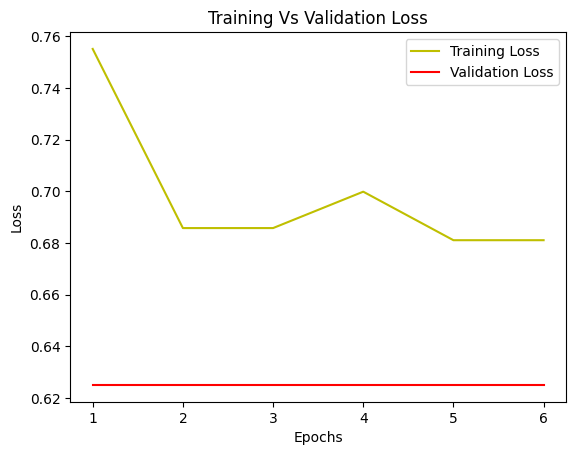

In [47]:
loss = history_a.history['loss']
val_loss = history_a.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label="Training Loss")
plt.plot(epochs, val_loss, 'r', label="Validation Loss")
plt.title("Training Vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

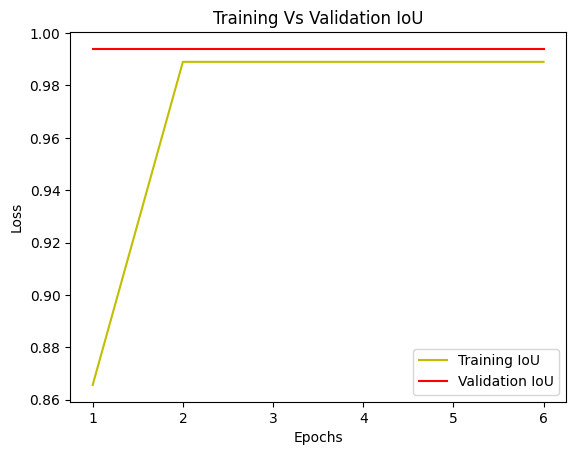

In [48]:
jaccard_coef = history_a.history['jaccard_coef']
val_jaccard_coef = history_a.history['val_jaccard_coef']

epochs = range(1, len(jaccard_coef) + 1)
plt.plot(epochs, jaccard_coef, 'y', label="Training IoU")
plt.plot(epochs, val_jaccard_coef, 'r', label="Validation IoU")
plt.title("Training Vs Validation IoU")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [49]:
model_history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [50]:
y_pred = model.predict(X_test)

C:\Users\Mathi\anaconda3\envs\lulc_seg\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 256, 256, 9))
  warnings.warn(msg)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 441ms/step


In [51]:
len(y_pred)

76

In [52]:
y_pred

array([[[[1., 0.],
         [1., 0.],
         [1., 0.],
         ...,
         [1., 0.],
         [1., 0.],
         [1., 0.]],

        [[1., 0.],
         [1., 0.],
         [1., 0.],
         ...,
         [1., 0.],
         [1., 0.],
         [1., 0.]],

        [[1., 0.],
         [1., 0.],
         [1., 0.],
         ...,
         [1., 0.],
         [1., 0.],
         [1., 0.]],

        ...,

        [[1., 0.],
         [1., 0.],
         [1., 0.],
         ...,
         [1., 0.],
         [1., 0.],
         [1., 0.]],

        [[1., 0.],
         [1., 0.],
         [1., 0.],
         ...,
         [1., 0.],
         [1., 0.],
         [1., 0.]],

        [[1., 0.],
         [1., 0.],
         [1., 0.],
         ...,
         [1., 0.],
         [1., 0.],
         [1., 0.]]],


       [[[1., 0.],
         [1., 0.],
         [1., 0.],
         ...,
         [1., 0.],
         [1., 0.],
         [1., 0.]],

        [[1., 0.],
         [1., 0.],
         [1., 0.],
         ...,
   

In [53]:
y_pred_argmax = np.argmax(y_pred, axis=3)
len(y_pred_argmax)
y_pred_argmax

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [54]:
y_test_argmax = np.argmax(y_test, axis=3)
y_test_argmax

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        ...,
        [0, 0, 0, ..., 

In [97]:
import random

test_image_number = random.randint(0, len(X_test))

test_image = X_test[test_image_number]
ground_truth_image = y_test_argmax[test_image_number]

test_image_input = np.expand_dims(test_image, 0)

prediction = model.predict(test_image_input)
predicted_image = np.argmax(prediction, axis=3)
predicted_image = predicted_image[0,:,:]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].


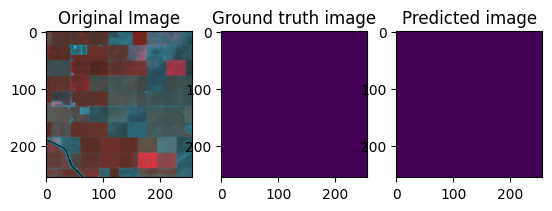

In [98]:
rgb_original = np.stack([test_image[:, :, 3],  # Red: Band 4
                      test_image[:, :, 2],  # Green: Band 3
                      test_image[:, :, 1]], axis=-1)  # Blue: Band 2

plt.figure()
plt.subplot(231)
plt.title("Original Image")
plt.imshow(rgb_original)
plt.subplot(232)
plt.title("Ground truth image")
plt.imshow(ground_truth_image)
plt.subplot(233)
plt.title("Predicted image")
plt.imshow(predicted_image)

In [100]:
model_save_path = "D:/forest_fire/forest_fire.keras"
model.save(model_save_path)
